In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.gravity_processing as grav

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle
import random 

import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
# choose resolution

layer_spacing = 5e3
# layer_spacing = 10e3

grav_spacing = 5e3
# grav_spacing = 10e3

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    f"../inversion_layers/RIS_starting_prisms_{int(layer_spacing)}k_constraints.zarr")

# partial bouguer corrected gravity data
df_anomalies = pd.read_csv(
    "../data/RIS_bouguer_corrections_50k_filt_mask.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
).drop(columns='bed_forward')

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
if layer_spacing == 5e3:
    constraints_fname = "../data/bed_constraints_5k.csv.gz"
elif layer_spacing == 10e3:
    constraints_fname = "../data/bed_constraints_10k.csv.gz"
else:
    raise ValueError("No constraint point files available at specified spacing!")
    
constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# mark points inside grounding line as "inside"
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()
gdf = gpd.GeoDataFrame(
    constraints,
    geometry=gpd.points_from_xy(x=constraints.easting, y=constraints.northing),
    crs = "EPSG:3031")
constraints["inside"] = gdf.within(RIS.geometry[0])
constraints.drop(columns="geometry", inplace=True)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
print(f"bathymetry control points:{len(constraints)}")

# surface
fname = "../inversion_layers/bedmachine_surface.zarr"
surface = xr.open_zarr(fname).surface

# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing = layer_spacing,
    region = buffer_region,
    registration = registration,
    verbose = "q",
)

# bed
bedmachine_bed = xr.open_zarr("../inversion_layers/bedmachine_bed.zarr")["bed"]
bedmachine_bed_layer_spacing = fetch.resample_grid(
    bedmachine_bed,
    spacing = layer_spacing,
    region = buffer_region,
    registration = registration,
    verbose = "q",
)

# final inverted bathymetry model
fname = "../results/weights_mask_prism_results.csv.gz"
inverted_bathy = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inverted_bathy = inverted_bathy.set_index(["northing", "easting"]
                ).to_xarray()[inverted_bathy.columns[-1]]

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-580000.0, 385000.0, -1385000.0, -445000.0)
buffer region =  [-620000.0, 460000.0, -1460000.0, -380000.0]
bathymetry control points:28087
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


In [4]:
# fig = maps.basemap(region=buffer_region,)

# fig.plot(RIS, pen="0.6p,black")

# fig.plot(
#     x=constraints[~constraints.inside].easting,
#     y=constraints[~constraints.inside].northing,
#     style="c0.05c",
#     fill="blue",
# )

# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     style="c0.1c",
#     fill="red",
# )

# fig.show()


# Add uncertainties to constraints
All points inside RIS get a standard 5% depth uncertainty
Depth is defined as distance from ice surface to reported bed.

In [5]:
# sample ice surface elevation into dataframe
# from bedmachine, 
constraints = profile.sample_grids(
    constraints,
    surface,
    "surface_z_ellipsoidal",
    coord_names=["easting", "northing"],
)

# calculate error as 5% of depth from surface
constraints["z_error"] = 10
depth = constraints[constraints.inside].surface_z_ellipsoidal - \
        constraints[constraints.inside].upward
uncert =  0.05 * depth

constraints.loc[constraints[constraints.inside].index, "z_error"] = uncert

constraints["low_lim"] = constraints.upward - constraints.z_error
constraints["high_lim"] = constraints.upward + constraints.z_error

print(f"mean uncertainty inside RIS: {np.nanmean(constraints[constraints.inside].z_error)} m")
print(f"mean uncertainty outside RIS: {np.nanmean(constraints[constraints.inside==False].z_error)} m")
constraints.describe()    

mean uncertainty inside RIS: 33.46741474651805 m
mean uncertainty outside RIS: 10.0 m


,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,surface_z_ellipsoidal,low_lim,high_lim
count,2.808700e+04,28087.000000,28087.000000,223.000000,223.000000,223.000000,0.0,28087.000000,0.0,28087.000000,28087.000000,28087.000000
mean,-8.756051e+05,-90456.515288,-18.108343,-80.352235,-9.656647,13.699552,NaN,10.186322,NaN,823.526287,-28.294665,-7.922021
std,3.686328e+05,357858.552976,1030.160378,1.687297,168.173939,8.608311,NaN,2.207073,NaN,1002.110461,1030.291970,1030.033498
min,-1.460000e+06,-620000.000000,-3737.661133,-84.600000,-179.819200,1.000000,NaN,10.000000,NaN,-61.000000,-3747.661133,-3727.661133
25%,-1.280917e+06,-425000.000000,-651.421906,-81.603470,-165.579050,1.000000,NaN,10.000000,NaN,-54.000000,-661.601593,-641.189209
50%,-7.550000e+05,-120000.000000,-452.590332,-79.976110,-154.674400,19.000000,NaN,10.000000,NaN,338.849823,-462.769196,-442.387787
75%,-5.450000e+05,270000.000000,566.328583,-79.044165,170.377200,19.000000,NaN,10.000000,NaN,1704.700073,556.328583,576.328583
max,-3.800000e+05,460000.000000,4053.667969,-77.656670,179.950300,25.000000,NaN,69.764264,NaN,4220.422852,4043.667969,4063.667969


In [6]:
# grav.plotly_points(
#     constraints[constraints.inside],
#     color_col="z_error",
#     hover_cols=["station_ID", "surface_z_ellipsoidal", "upward", "low_lim", "high_lim"],
#     robust=True,
#     point_size=4,
# )

# Setup Monte-Carlo sampling with constraints uncertainties
* define a Boxcar samping method for the uncertainties of the constraint points
* run full inversion with sampled constraints
    * including: 
        * starting bed model
        * forward gravity of bed
        * regional / residual seperation
        * inversion
* find standard deviation per grid cell of all resulting inverted bathymetry models

## Sample constraint uncertainties
ideas from: https://aegis4048.github.io/uncertainty-modeling-with-monte-carlo-simulation
types of distrubtions to sample: https://numpy.org/doc/stable/reference/random/generator.html#distributions

In [7]:
sampled_constraints = constraints.copy()

# create random generator
rand = np.random.default_rng(seed=0)

upward_sampled = rand.uniform(constraints.low_lim, constraints.high_lim)

sampled_constraints["upward"] = upward_sampled

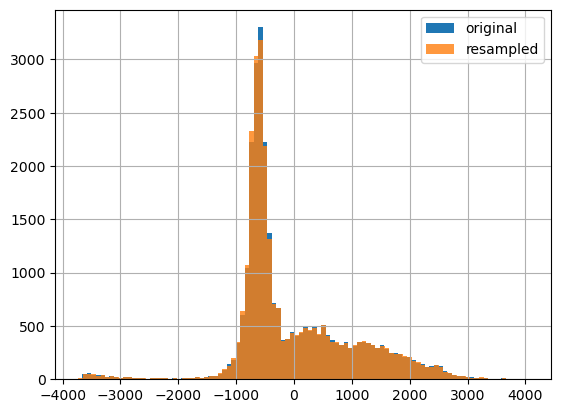

In [8]:
ax = constraints.upward.hist(bins=100, label="original")
sampled_constraints.upward.hist(bins=100, label="resampled", alpha=.8, ax=ax)
ax.legend()

## Run inversion workflow

In [9]:
bedmachine_df_buffer, _, bedmachine_masked = inv_utils.bedmachine_buffer_points(
    buffer_width=20e3,
    bedmachine_bed=bedmachine_bed_layer_spacing,
    # plot=True,
)

In [11]:
starting_bed_args = {
    "region": buffer_region,
    "spacing": layer_spacing,
    "icebase": icebase_layer_spacing.rename({"x":"easting", "y":"northing"}),
}

anomaly_args = {
    "grav_spacing": grav_spacing,
    "inversion_region": inversion_region,
}
 
inversion_args = {
    "input_grav_column": "Gobs_corr_shift",
    "apply_weights": True,
    "max_iterations": 20,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 0.8,
    "perc_increase_limit": 0.2,
    "upper_confining_layer": icebase_layer_spacing,
    "deriv_type": "annulus",
    "solver_type": "scipy least squares",
    "solver_damping": 0.1, #0.001 very slow per iter
}

sampled_constraints = constraints.copy()

# if file exists, start and next run, else start at 0
fname = "../data/monte_carlo_constraint_outside_topos.zarr"
try: 
    topos = xr.open_zarr(fname)
    starting_run = len(topos)
except FileNotFoundError: 
    print(f"File {fname} not found, creating new file") 
    starting_run = 0

# runs = 50
# for i in range(starting_run, runs):
#     if i == starting_run:
#     print(f"starting Monte Carlo uncertainty analysis at run # {starting run} of {runs}\n",
#           f"saving results to '{fname}'")
#     # create random generator
#     rand = np.random.default_rng(seed=i)
    
#     # sample all constraints
#     upward_sampled = rand.uniform(constraints.low_lim, constraints.high_lim)
#     sampled_constraints["upward"] = upward_sampled
    
#     # re-grid constraints outside RIS 
#     masked_bed = sampled_constraints[sampled_constraints.inside==False]\
#         .set_index(["northing","easting"]).to_xarray().upward
    
#     # get new buffer zone points
#     buffer_points = pd.merge(
#         sampled_constraints.reset_index(), 
#         bedmachine_df_buffer[["northing","easting"]], how='inner').set_index("index")
#     buffer_points = buffer_points[["northing","easting","upward"]]
    
#     with inv_utils.HiddenPrints():
#         topo = inv_utils.inversion_varying_constraints(
#             sampled_constraints,
#             df_anomalies,
#             starting_prisms.weights,
#             masked_bed,
#             buffer_points,
#             starting_bed_args,
#             anomaly_args,
#             inversion_args,
#         )
        
#     #rename grid with run number
#     topo = topo.to_dataset(name=f"run_{i}")
    
#     if i == 0: mode = "w"
#     else: mode = "a"
        
#     enc = {x: {"compressor": zarr.Blosc()} for x in topo}
#     topo.to_zarr(
#         fname,
#         encoding=enc,
#         mode=mode,
#     )
#     print(f"Finished inversion {i+1} of {runs}")

In [12]:
# load dataset with all the topo models
topos = xr.open_zarr(fname)

# merge variables into a single variable with a new axis "folds"
variables = list(topos)
ds_merged  = xr.concat([topos[var] for var in variables], dim="runs")\
    .assign_coords({"runs": variables})\
    .rename("run_num")\
    .to_dataset()
ds_merged

<xarray.Dataset>
Dimensions:   (easting: 217, northing: 217, runs: 50)
Coordinates:
  * easting   (easting) float64 -6.2e+05 -6.15e+05 -6.1e+05 ... 4.55e+05 4.6e+05
  * northing  (northing) float64 -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
  * runs      (runs) <U6 'run_0' 'run_1' 'run_10' ... 'run_7' 'run_8' 'run_9'
Data variables:
    run_num   (runs, northing, easting) float64 dask.array<chunksize=(1, 109, 217), meta=np.ndarray>

## Calculate standard deviation
* calculate standard deviation of each grid cell for the entire suite of invert bathymetries

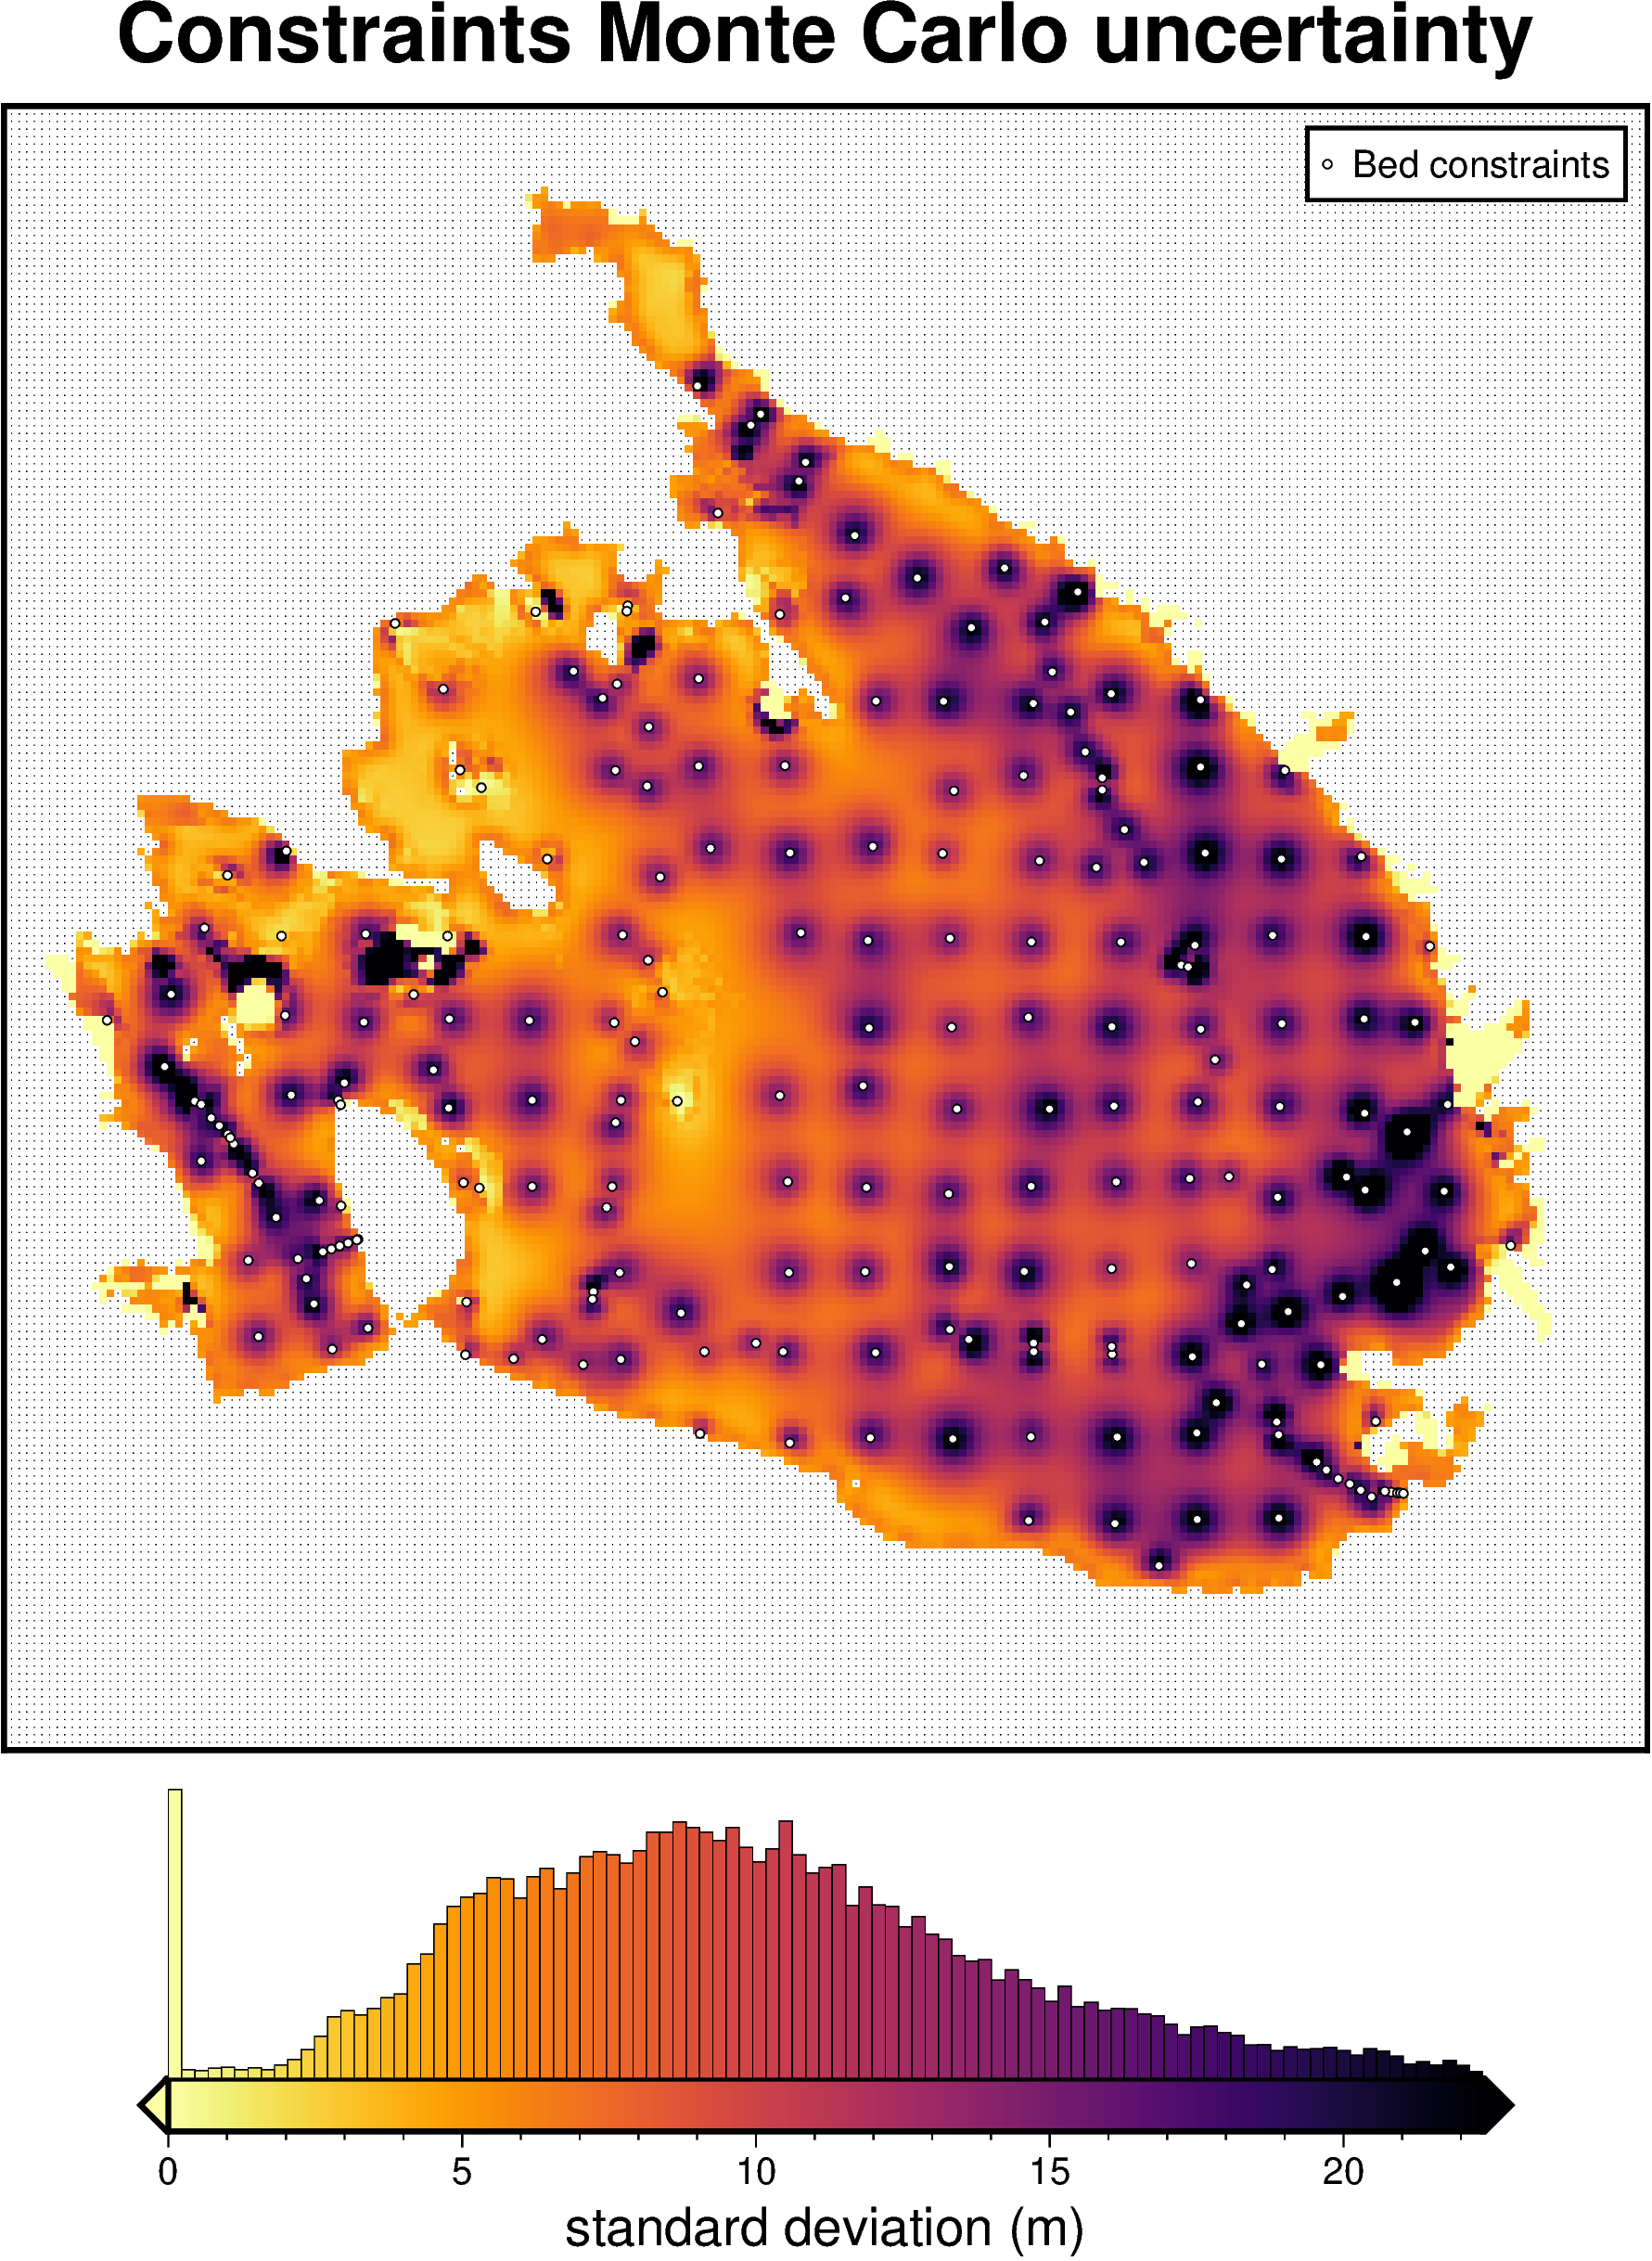

In [17]:
grd = ds_merged['run_num'].std("runs").rename("z_std")
grd = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = grd, masked=True, invert=False)

fig = maps.plot_grd(
    grd, 
    cmap="inferno",
    reverse_cpt=True,
    robust=True, 
    hist=True, 
    cbar_label="standard deviation (m)", 
    title='Constraints Monte Carlo uncertainty',
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    fill="black",
    style="c.01c",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    fill="white",
    pen=".3p,black",
    style="c.08c",
    label="Bed constraints",
)
fig.legend()

fig.show()

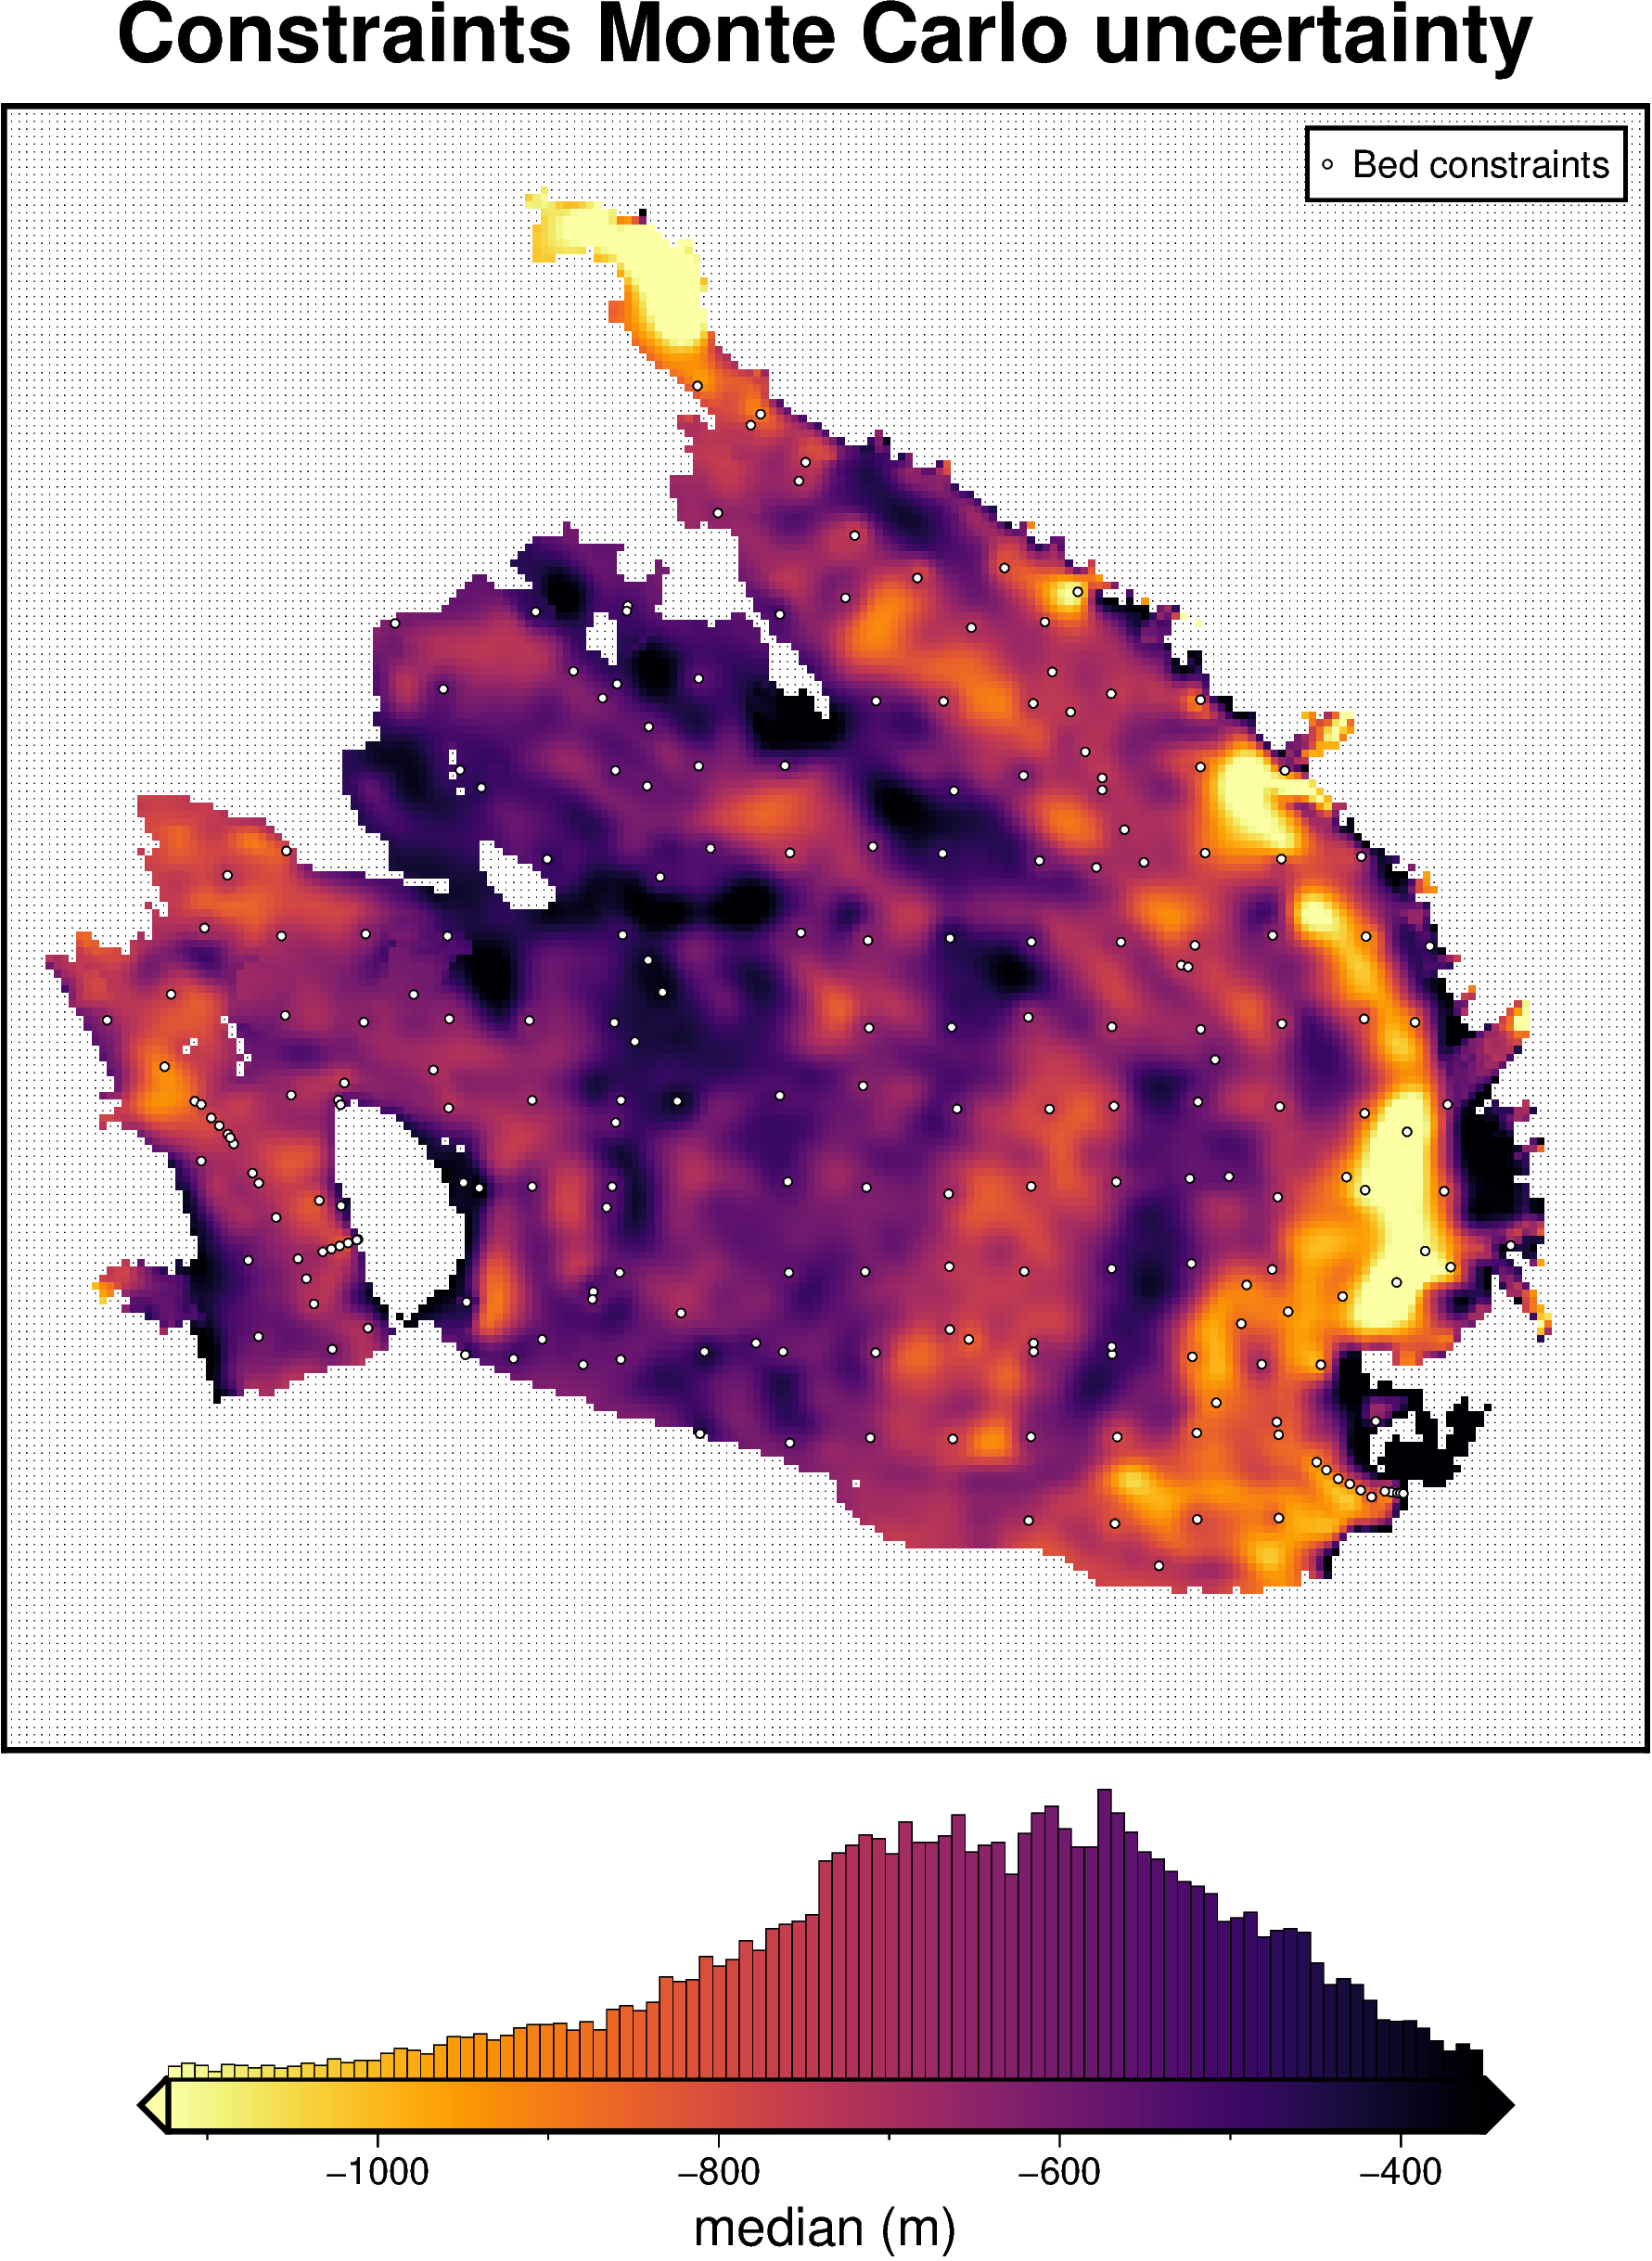

In [18]:
grd = ds_merged['run_num'].median("runs").rename("z_median")
grd = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = grd, masked=True, invert=False)

fig = maps.plot_grd(
    grd, 
    cmap="inferno",
    reverse_cpt=True,
    robust=True, 
    hist=True, 
    cbar_label="median (m)", 
    title='Constraints Monte Carlo uncertainty',
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    fill="black",
    style="c.01c",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    fill="white",
    pen=".3p,black",
    style="c.08c",
    label="Bed constraints",
)
fig.legend()

fig.show()

In [14]:
# merged_min = ds_merged['run_num'].min("runs")
# merged_max = ds_merged['run_num'].max("runs")
# merged_min = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = merged_min, masked=True, invert=False)
# merged_max = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = merged_max, masked=True, invert=False)

# _ = utils.grd_compare(
#     merged_min, 
#     merged_max, 
#     plot=True,
#     grid1_name="Min",
#     grid2_name="Max",
#     title='Monte Carlo analysis with constraints',
#     cbar_label="variance (m)",
#     diff_cmap="inferno",
#     diff_maxabs=False,
#     cmap="rain",
#     reverse_cpt=True,    
#     rmse_in_title=False,
#     subplot_labels=True,
#     robust=True,
#     hist=True,   
#     # shp_mask="../plotting/RIS_outline.shp",
# )

In [15]:
# inverted_bathy_mask = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = inverted_bathy, masked=True, invert=False)
# max_to_final = merged_max - inverted_bathy_mask
# min_to_final = merged_min - inverted_bathy_mask

# fig = maps.plot_grd(
#     max_to_final,
#     title="Max variance - final model",
#     cmap="vik+h0",
#     robust=True,
#     hist=True,
# )
# fig = maps.plot_grd(
#     min_to_final,
#     title="Min variance - final model",
#     cmap="vik+h0",
#     robust=True,
#     hist=True,
#     fig = fig, 
#     origin_shift = "xshift",
# )
# fig.show()